The predictions are: 2.11602400 2.11602400 2.11602400 2.11602400 2.11602400 2.11602400 2.15390508 2.15390508 2.24051337 2.40166254
The actual values are: 1.76405 0.65268 1.48379 2.99847 2.87766 0.28535 2.46524 1.61632 1.91698 2.68333


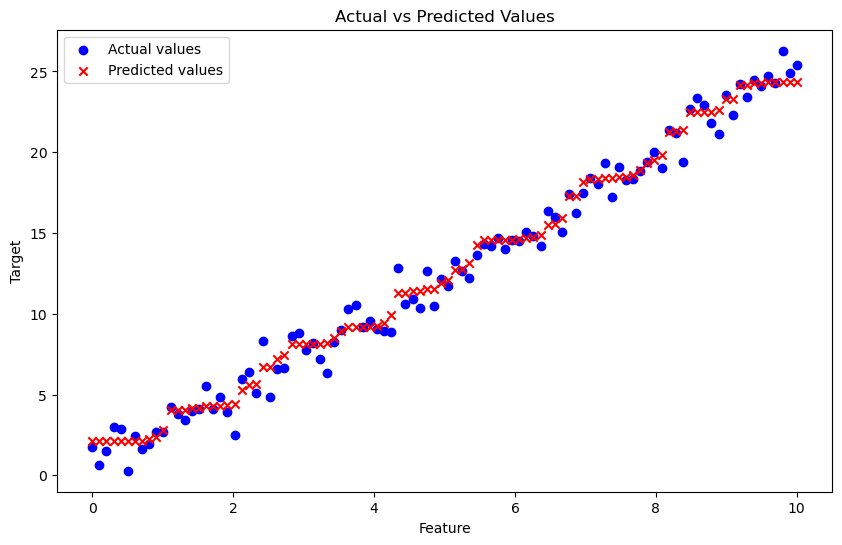

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class DecisionTreeRegressor:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._fit(X, y, depth=0)

    def _fit(self, X, y, depth):
        n_samples, n_features = X.shape
        mean_y = np.mean(y)
        
        # Stop if max_depth is reached or if all targets are the same
        if (self.max_depth and depth >= self.max_depth) or len(np.unique(y)) == 1:
            return mean_y
        
        best_split = None
        best_score = float('inf')
        best_left_y = None
        best_right_y = None
        
        for feature_index in range(n_features):
            feature_values = np.unique(X[:, feature_index])
            
            for value in feature_values:
                left_mask = X[:, feature_index] <= value
                right_mask = ~left_mask
                
                left_y = y[left_mask]
                right_y = y[right_mask]
                
                if len(left_y) == 0 or len(right_y) == 0:
                    continue
                
                left_variance = np.var(left_y)
                right_variance = np.var(right_y)
                
                score = (len(left_y) * left_variance + len(right_y) * right_variance) / n_samples
                
                if score < best_score:
                    best_score = score
                    best_split = (feature_index, value)
                    best_left_y = left_y
                    best_right_y = right_y
        
        if best_split is None:
            return mean_y
        
        left_tree = self._fit(X[X[:, best_split[0]] <= best_split[1]], best_left_y, depth + 1)
        right_tree = self._fit(X[X[:, best_split[0]] > best_split[1]], best_right_y, depth + 1)
        
        return (best_split, left_tree, right_tree)

    def predict(self, X):
        return np.array([self._predict(x, self.tree) for x in X])

    def _predict(self, x, tree):
        if not isinstance(tree, tuple):
            return tree
        
        feature_index, value = tree[0]
        if x[feature_index] <= value:
            return self._predict(x, tree[1])
        else:
            return self._predict(x, tree[2])


class RandomForestRegressor:
    def __init__(self, n_estimators=10, max_depth=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        for _ in range(self.n_estimators):
            # Bootstrap sampling
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample, y_sample = X[indices], y[indices]
            
            # Train a decision tree on the bootstrap sample
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        # Aggregate predictions from all trees
        tree_predictions = np.zeros((X.shape[0], self.n_estimators))
        for i, tree in enumerate(self.trees):
            tree_predictions[:, i] = tree.predict(X)
        return np.mean(tree_predictions, axis=1)


# Example usage
if __name__ == "__main__":
    np.random.seed(0)
    
    # Generate synthetic data
    X = np.linspace(0, 10, 100).reshape(-1, 1)
    y = 2.5 * X.squeeze() + np.random.normal(0, 1, X.shape[0])
    
    # Create and train the Random Forest Regressor
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=3)
    rf_model.fit(X, y)
    
    # Make predictions
    predictions = rf_model.predict(X)
    
    # Display predictions and actual values
    print("The predictions are:", " ".join(f"{val:.8f}" for val in predictions[:10]))
    print("The actual values are:", " ".join(f"{val:.5f}" for val in y[:10]))
    
    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, color='blue', label='Actual values')
    plt.scatter(X, predictions, color='red', label='Predicted values', marker='x')
    plt.xlabel('Feature')
    plt.ylabel('Target')
    plt.title('Actual vs Predicted Values')
    plt.legend()
    plt.show()